In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading model metrics

try:
    baseline_metrics = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_model_metrics.csv')
    lstm_metrics = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_model_metrics.csv')
    print(" Baseline (Linear Regression) metrics loaded")
    print(" LSTM metrics loaded")
except FileNotFoundError as e:
    print(f" Error: {e}")
    print("Please run Module 4 and Module 5 first")
    exit()

# Extract test metrics
baseline_test = baseline_metrics[baseline_metrics['Dataset'] == 'Test'].iloc[0]
lstm_test = lstm_metrics[lstm_metrics['Dataset'] == 'Test'].iloc[0]

print("\n Test Set Metrics Summary:")
print(f"\n{'Metric':<15} {'Linear Regression':>20} {'LSTM':>20}")
for metric in ['MAE', 'RMSE', 'R² Score', 'MAPE (%)']:
    print(f"{metric:<15} {baseline_test[metric]:>20.4f} {lstm_test[metric]:>20.4f}")

 Baseline (Linear Regression) metrics loaded
 LSTM metrics loaded

 Test Set Metrics Summary:

Metric             Linear Regression                 LSTM
MAE                           0.0030               0.3136
RMSE                          0.0103               0.4526
R² Score                      0.9998               0.5746
MAPE (%)                      0.6446              41.8596


In [4]:
# Detailed Model Comparison

# Compare across all datasets
print("\n FULL COMPARISON TABLE:")

comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R² Score', 'MAPE (%)'],
})

for dataset in ['Training', 'Validation', 'Test']:
    bl = baseline_metrics[baseline_metrics['Dataset'] == dataset].iloc[0]
    lt = lstm_metrics[lstm_metrics['Dataset'] == dataset].iloc[0]
    comparison[f'LR_{dataset}'] = [bl['MAE'], bl['RMSE'], bl['R² Score'], bl['MAPE (%)']]
    comparison[f'LSTM_{dataset}'] = [lt['MAE'], lt['RMSE'], lt['R² Score'], lt['MAPE (%)']]

print(comparison.to_string(index=False))

# Determine winner for each metric
print("\n METRIC-WISE WINNER:")
metrics_to_compare = ['MAE', 'RMSE', 'R² Score', 'MAPE (%)']
lstm_wins = 0
lr_wins = 0

for metric in metrics_to_compare:
    bl_val = baseline_test[metric]
    lt_val = lstm_test[metric]
    
    # For MAE, RMSE, MAPE: lower is better
    # For R²: higher is better
    if metric == 'R² Score':
        winner = 'LSTM' if lt_val > bl_val else 'Linear Regression'
        improvement = abs(lt_val - bl_val) / bl_val * 100
    else:
        winner = 'LSTM' if lt_val < bl_val else 'Linear Regression'
        improvement = abs(bl_val - lt_val) / bl_val * 100
    
    if winner == 'LSTM':
        lstm_wins += 1
    else:
        lr_wins += 1
    
    print(f"   {metric:<12}: {winner:<22} (improvement: {improvement:.2f}%)")

print(f"\n OVERALL WINNER: {'LSTM' if lstm_wins > lr_wins else 'Linear Regression'}")
print(f"   LSTM wins: {lstm_wins}/4 metrics")
print(f"   LR wins:   {lr_wins}/4 metrics")


 FULL COMPARISON TABLE:
  Metric  LR_Training  LSTM_Training  LR_Validation  LSTM_Validation  LR_Test  LSTM_Test
     MAE     0.001470       0.351896       0.012870         0.364045 0.002968   0.313551
    RMSE     0.004142       0.506006       0.109332         0.512050 0.010315   0.452566
R² Score     0.999979       0.677993       0.984240         0.654908 0.999779   0.574551
MAPE (%)     0.261209      48.372186       0.735895        39.968079 0.644563  41.859615

 METRIC-WISE WINNER:
   MAE         : Linear Regression      (improvement: 10463.94%)
   RMSE        : Linear Regression      (improvement: 4287.64%)
   R² Score    : Linear Regression      (improvement: 42.53%)
   MAPE (%)    : Linear Regression      (improvement: 6394.26%)

 OVERALL WINNER: Linear Regression
   LSTM wins: 0/4 metrics
   LR wins:   4/4 metrics


In [5]:
# Selecting Best Model

# Decision based on R² score (primary) and MAE (secondary)
lstm_r2 = lstm_test['R² Score']
lr_r2 = baseline_test['R² Score']

if lstm_r2 > lr_r2:
    best_model_name = 'LSTM'
    print(f"\n SELECTED: LSTM Model")
    print(f"   Reason: Higher R² Score ({lstm_r2:.4f} vs {lr_r2:.4f})")
else:
    best_model_name = 'Linear Regression'
    print(f"\n SELECTED: Linear Regression")
    print(f"   Reason: Higher R² Score ({lr_r2:.4f} vs {lstm_r2:.4f})")
    print(f"   Note: LSTM didn't outperform - consider more tuning")

print(f"\n Best Model Performance (Test Set):")
best_metrics = lstm_test if best_model_name == 'LSTM' else baseline_test
print(f"   • R² Score: {best_metrics['R² Score']:.4f}")
print(f"   • MAE:      {best_metrics['MAE']:.4f} kW")
print(f"   • RMSE:     {best_metrics['RMSE']:.4f} kW")
print(f"   • MAPE:     {best_metrics['MAPE (%)']:.2f}%")


 SELECTED: Linear Regression
   Reason: Higher R² Score (0.9998 vs 0.5746)
   Note: LSTM didn't outperform - consider more tuning

 Best Model Performance (Test Set):
   • R² Score: 0.9998
   • MAE:      0.0030 kW
   • RMSE:     0.0103 kW
   • MAPE:     0.64%


In [6]:
# Loading Predictions for Visual Comparison

baseline_preds = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_model_predictions.csv')
lstm_preds = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_model_predictions.csv')

print(f" Baseline predictions: {len(baseline_preds):,} samples")
print(f" LSTM predictions: {len(lstm_preds):,} samples")

# Align lengths (use shorter one)
min_len = min(len(baseline_preds), len(lstm_preds))
baseline_preds = baseline_preds.iloc[:min_len].reset_index(drop=True)
lstm_preds = lstm_preds.iloc[:min_len].reset_index(drop=True)

# CREATE ABSOLUTE_ERROR COLUMN (compute from Error column)
baseline_preds['Absolute_Error'] = baseline_preds['Error'].abs()
lstm_preds['Absolute_Error'] = lstm_preds['Error'].abs()

print(" Absolute_Error column created for both models")

 Baseline predictions: 5,164 samples
 LSTM predictions: 5,140 samples
 Absolute_Error column created for both models


 Visualization saved as 'module6_model_comparison.png'


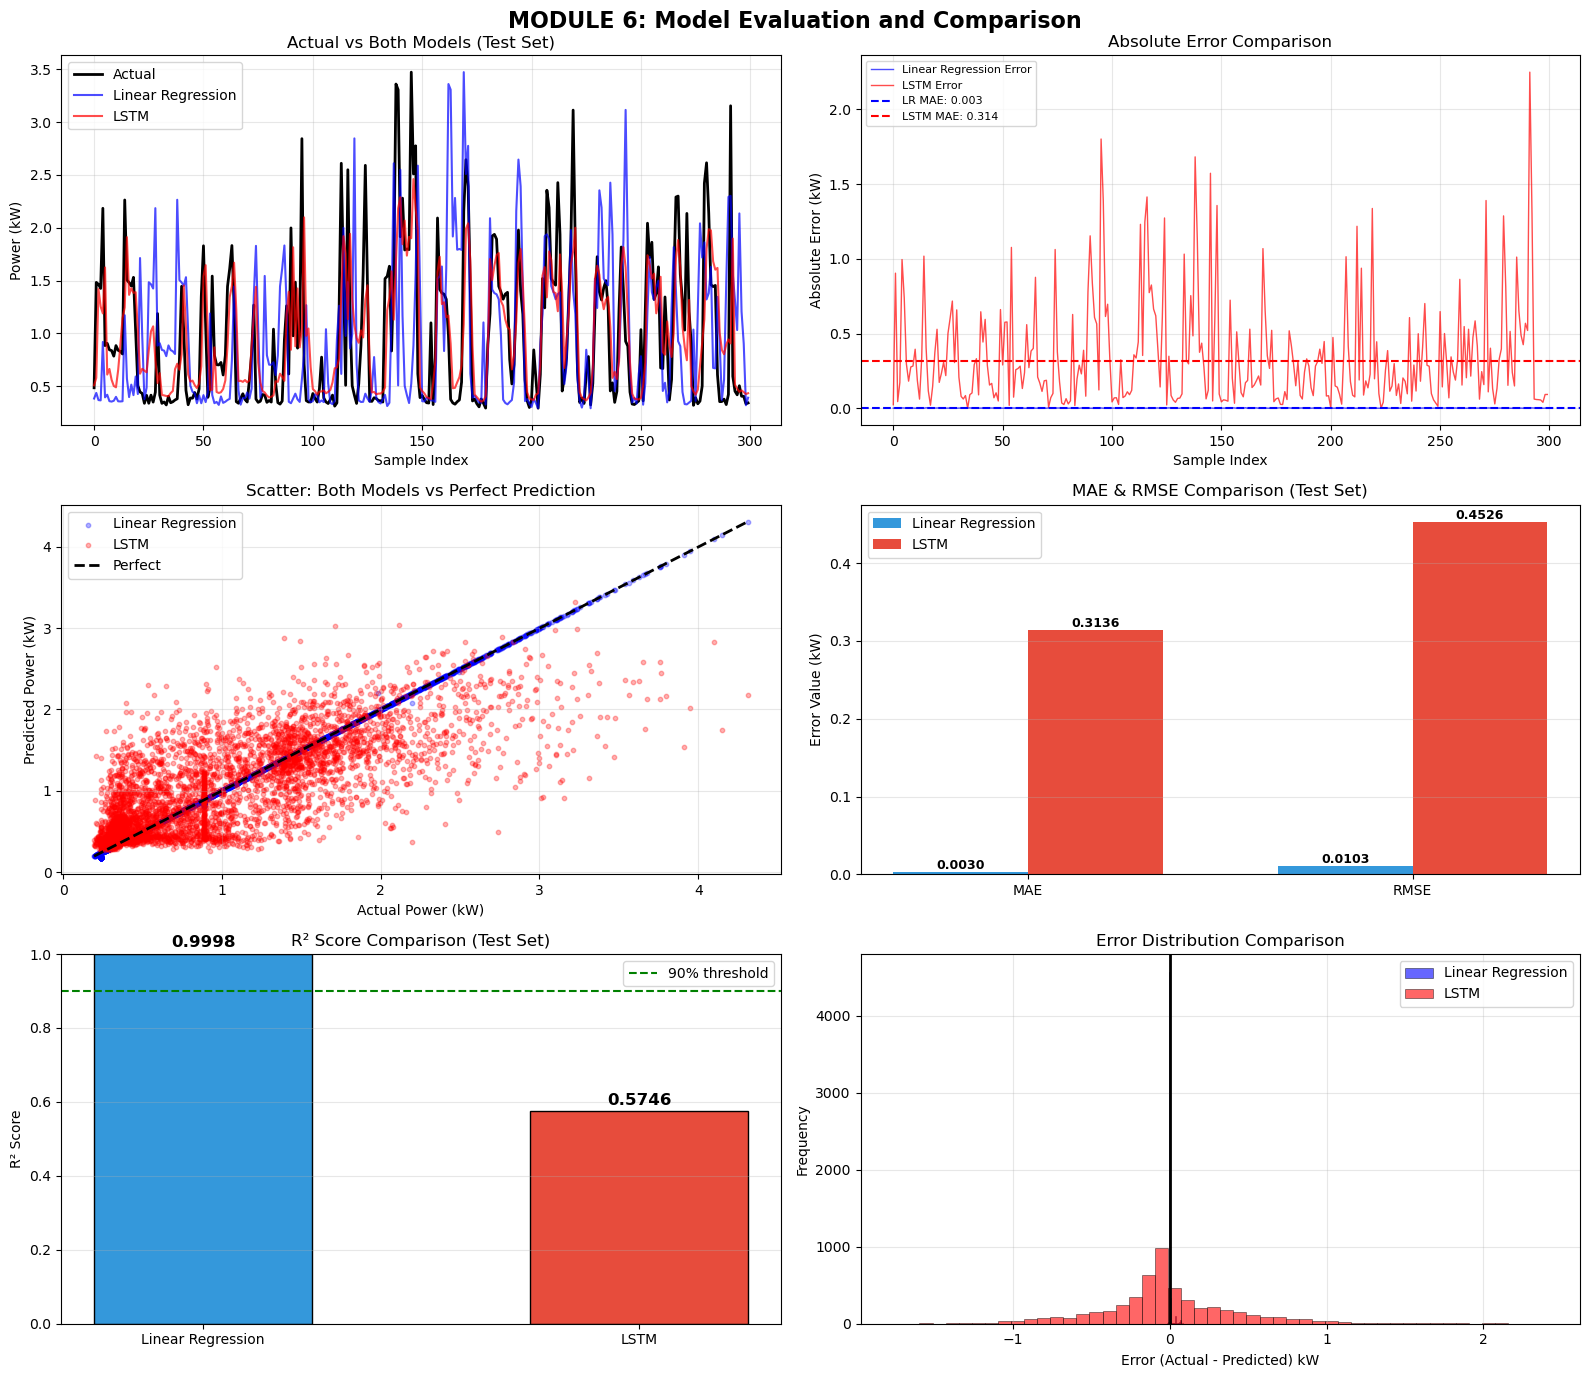

In [7]:
# Creating Evaluation Visualizations

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('MODULE 6: Model Evaluation and Comparison', fontsize=16, fontweight='bold')

# Plot 1: Side-by-side Actual vs Predicted
ax1 = axes[0, 0]
sample = min(300, min_len)
ax1.plot(range(sample), lstm_preds['Actual'].iloc[:sample],
        label='Actual', linewidth=2, color='black')
ax1.plot(range(sample), baseline_preds['Predicted'].iloc[:sample],
        label='Linear Regression', linewidth=1.5, alpha=0.7, color='blue')
ax1.plot(range(sample), lstm_preds['Predicted'].iloc[:sample],
        label='LSTM', linewidth=1.5, alpha=0.7, color='red')
ax1.set_title('Actual vs Both Models (Test Set)')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Power (kW)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Error Comparison
ax2 = axes[0, 1]
ax2.plot(range(sample), baseline_preds['Absolute_Error'].iloc[:sample], 
        label='Linear Regression Error', linewidth=1, alpha=0.7, color='blue')
ax2.plot(range(sample), lstm_preds['Absolute_Error'].iloc[:sample], 
        label='LSTM Error', linewidth=1, alpha=0.7, color='red')
ax2.axhline(y=baseline_test['MAE'], color='blue', linestyle='--', 
        linewidth=1.5, label=f'LR MAE: {baseline_test["MAE"]:.3f}')
ax2.axhline(y=lstm_test['MAE'], color='red', linestyle='--', 
        linewidth=1.5, label=f'LSTM MAE: {lstm_test["MAE"]:.3f}')
ax2.set_title('Absolute Error Comparison')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Absolute Error (kW)')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# Plot 3: Scatter Plot Comparison
ax3 = axes[1, 0]
ax3.scatter(baseline_preds['Actual'], baseline_preds['Predicted'], 
        alpha=0.3, s=10, color='blue', label='Linear Regression')
ax3.scatter(lstm_preds['Actual'], lstm_preds['Predicted'], 
        alpha=0.3, s=10, color='red', label='LSTM')
min_val = baseline_preds['Actual'].min()
max_val = baseline_preds['Actual'].max()
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')
ax3.set_title('Scatter: Both Models vs Perfect Prediction')
ax3.set_xlabel('Actual Power (kW)')
ax3.set_ylabel('Predicted Power (kW)')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Metrics Bar Chart (Test Set)
ax4 = axes[1, 1]
metrics_names = ['MAE', 'RMSE']
x = np.arange(len(metrics_names))
width = 0.35

lr_vals = [baseline_test['MAE'], baseline_test['RMSE']]
lstm_vals = [lstm_test['MAE'], lstm_test['RMSE']]

bars1 = ax4.bar(x - width/2, lr_vals, width, label='Linear Regression', color='#3498DB')
bars2 = ax4.bar(x + width/2, lstm_vals, width, label='LSTM', color='#E74C3C')

ax4.set_title('MAE & RMSE Comparison (Test Set)')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_names)
ax4.set_ylabel('Error Value (kW)')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h,
                f'{h:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: R² Score Comparison
ax5 = axes[2, 0]
models = ['Linear Regression', 'LSTM']
r2_scores = [baseline_test['R² Score'], lstm_test['R² Score']]
colors = ['#3498DB', '#E74C3C']
bars = ax5.bar(models, r2_scores, color=colors, edgecolor='black', width=0.5)
ax5.set_title('R² Score Comparison (Test Set)')
ax5.set_ylabel('R² Score')
ax5.set_ylim(0, 1.0)
ax5.axhline(y=0.9, color='green', linestyle='--', linewidth=1.5, label='90% threshold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, r2_scores):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 6: Error Distribution (Histogram)
ax6 = axes[2, 1]
ax6.hist(baseline_preds['Error'], bins=50, alpha=0.6, color='blue', 
         label='Linear Regression', edgecolor='black', linewidth=0.5)
ax6.hist(lstm_preds['Error'], bins=50, alpha=0.6, color='red', 
         label='LSTM', edgecolor='black', linewidth=0.5)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax6.set_title('Error Distribution Comparison')
ax6.set_xlabel('Error (Actual - Predicted) kW')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('C:/Users/battu/Documents/SmartEnergyML/notebooks/visualizations/module6_model_comparison.png', dpi=300, bbox_inches='tight')
print(" Visualization saved as 'module6_model_comparison.png'")
plt.show()

In [ ]:
# Creating Flask-Compatible Prediction Function


#  Load LSTM features if file exists
if os.path.exists('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_selected_features.txt'):
    with open('C:/Users/battu/Documents/SmartEnergyML/data/processed/lstm_selected_features.txt', 'r') as f:
        lstm_features = [line.strip() for line in f if line.strip()]
else:
    lstm_features = []

# Create prediction module (flask_prediction.py)
flask_prediction_code = f'''"""
Flask-Compatible Prediction Module
Smart Energy Consumption Analysis
Supports both LSTM and Linear Regression models
"""

import numpy as np
import pandas as pd
import joblib
import os
import traceback

try:
    import tensorflow as tf
    from tensorflow import keras
    TENSORFLOW_AVAILABLE = True
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("WARNING: TensorFlow not available")


def load_selected_features():
    """Load the exact feature list used during training"""
    feature_file = 'data/processed/lstm_selected_features.txt'
    
    if os.path.exists(feature_file):
        with open(feature_file, 'r') as f:
            features = [line.strip() for line in f.readlines() if line.strip()]
        print(f"Loaded {len(features)} features from {feature_file}")
        return features
    else:
        print(f"WARNING: Feature file not found at {feature_file}")
        return None


def create_features(df):
    """Create all engineered features"""
    df = df.copy()
    
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Lag features
    for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
        df[f'Global_active_power_lag_{lag}h'] = df['Global_active_power'].shift(lag)
    
    # Difference features
    df['Global_active_power_diff_1h'] = df['Global_active_power'].diff(1)
    df['Global_active_power_diff_24h'] = df['Global_active_power'].diff(24)
    
    # Rolling statistics
    for window in [6, 24, 168]:
        df[f'Global_active_power_rolling_mean_{window}h'] = df['Global_active_power'].rolling(window=window, min_periods=1).mean()
    
    df['Global_active_power_rolling_std_24h'] = df['Global_active_power'].rolling(window=24, min_periods=1).std()
    
    # Exponential Moving Average
    df['Global_active_power_ema_24h'] = df['Global_active_power'].ewm(span=24, adjust=False).mean()
    
    # Momentum
    df['Global_active_power_momentum_24h'] = df['Global_active_power'] - df['Global_active_power'].shift(24)
    
    # Time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    
    # Season
    df['season'] = df.index.month % 12 // 3 + 1
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Sub-metering features
    if 'Sub_metering_1' in df.columns:
        df['total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
        df['Sub_metering_1_lag_24h'] = df['Sub_metering_1'].shift(24)
        df['Sub_metering_2_lag_24h'] = df['Sub_metering_2'].shift(24)
        df['Sub_metering_3_lag_24h'] = df['Sub_metering_3'].shift(24)
    
    # Fill NaN values
    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return df


def predict_fallback(input_data):
    """Simple fallback prediction"""
    try:
        current_power = float(input_data['Global_active_power'].iloc[-1])
        avg_24h = float(input_data['Global_active_power'].tail(24).mean())
        predicted_power = (current_power * 0.7) + (avg_24h * 0.3)
        
        return {
            'success': True,
            'prediction': round(predicted_power, 3),
            'current_power': round(current_power, 3),
            'change': round(predicted_power - current_power, 3),
            'change_percent': round((predicted_power - current_power) / current_power * 100, 2) if current_power > 0 else 0,
            'method': 'fallback',
            'message': 'Using simple average prediction'
        }
    except Exception as e:
        return {
            'success': False,
            'prediction': 0,
            'current_power': 0,
            'change': 0,
            'change_percent': 0,
            'error': str(e)
        }


def predict(input_data):
    """Make predictions using the trained LSTM model"""
    
    try:
        print("="*60)
        print("PREDICTION STARTED")
        print("="*60)
        
        if not TENSORFLOW_AVAILABLE:
            print("TensorFlow not available, using fallback")
            return predict_fallback(input_data)
        
        # Validate input
        if input_data is None or len(input_data) == 0:
            return {'success': False, 'prediction': 0, 'current_power': 0, 'change': 0, 'change_percent': 0, 'error': 'No input data'}
        
        if 'Global_active_power' not in input_data.columns:
            return {'success': False, 'prediction': 0, 'current_power': 0, 'change': 0, 'change_percent': 0, 'error': 'Global_active_power column missing'}
        
        current_power = float(input_data['Global_active_power'].iloc[-1])
        print(f"Current power: {current_power:.3f} kW")
        
        # UPDATED: Load new model format
        model_path = 'data/processed/lstm_model_new.keras'
        
        # Fallback to old model if new one doesn't exist
        if not os.path.exists(model_path):
            print(f"New model not found, trying old format...")
            model_path = 'data/processed/lstm_energy_prediction_model.h5'
        
        if not os.path.exists(model_path):
            print(f"Model not found at {model_path}")
            return predict_fallback(input_data)
        
        print(f"Loading model from: {model_path}")
        
        # Load model
        try:
            model = keras.models.load_model(model_path, compile=False)
            print("✓ Model loaded successfully!")
        except Exception as e:
            print(f"✗ Failed to load model: {str(e)[:100]}")
            return predict_fallback(input_data)
        
        # Load scalers
        feature_scaler_path = 'data/processed/lstm_feature_scaler.pkl'
        target_scaler_path = 'data/processed/lstm_target_scaler.pkl'
        
        feature_scaler = None
        target_scaler = None
        
        if os.path.exists(feature_scaler_path):
            feature_scaler = joblib.load(feature_scaler_path)
            print("✓ Feature scaler loaded")
        
        if os.path.exists(target_scaler_path):
            target_scaler = joblib.load(target_scaler_path)
            print("✓ Target scaler loaded")
        
        # Load selected features
        selected_features = load_selected_features()
        
        # Check if features already exist (from data_features_engineered.csv)
        if selected_features and all(f in input_data.columns for f in selected_features):
            print("✓ Features already present in data")
            df_features = input_data
        else:
            print("Creating features...")
            df_features = create_features(input_data)
        
        if selected_features is None:
            print("Feature list not found, using model input")
            # Based on your notebook - 29 features
            selected_features = [
                'Global_active_power_lag_1h',
                'Global_active_power_lag_2h',
                'Global_active_power_lag_3h',
                'Global_active_power_lag_6h',
                'Global_active_power_lag_12h',
                'Global_active_power_lag_24h',
                'Global_active_power_lag_48h',
                'Global_active_power_lag_168h',
                'Global_active_power_rolling_mean_6h',
                'Global_active_power_rolling_mean_24h',
                'Global_active_power_rolling_mean_168h',
                'Global_active_power_rolling_std_24h',
                'hour', 'hour_sin', 'hour_cos',
                'dayofweek', 'is_weekend',
                'month', 'month_sin', 'month_cos',
                'season',
                'total_sub_metering',
                'Sub_metering_1_lag_24h',
                'Sub_metering_2_lag_24h',
                'Sub_metering_3_lag_24h',
                'Global_active_power_diff_1h',
                'Global_active_power_diff_24h',
                'Global_active_power_ema_24h',
                'Global_active_power_momentum_24h',
            ]
        
        # Check for missing features
        available_features = [f for f in selected_features if f in df_features.columns]
        missing_features = [f for f in selected_features if f not in df_features.columns]
        
        if missing_features:
            print(f"WARNING: Missing {len(missing_features)} features: {missing_features[:5]}...")
            if len(available_features) < len(selected_features) * 0.8:
                print("Too many features missing, using fallback")
                return predict_fallback(input_data)
            selected_features = available_features
        
        print(f"✓ Using {len(selected_features)} features")
        
        # Prepare data
        X = df_features[selected_features].values
        
        # Scale features
        if feature_scaler is not None:
            X = feature_scaler.transform(X)
            print("✓ Features scaled")
        
        # Prepare sequence for LSTM (last 24 hours)
        sequence_length = 24
        if len(X) >= sequence_length:
            X_seq = X[-sequence_length:].reshape(1, sequence_length, len(selected_features))
        else:
            padding = np.zeros((sequence_length - len(X), len(selected_features)))
            X_padded = np.vstack([padding, X])
            X_seq = X_padded.reshape(1, sequence_length, len(selected_features))
        
        print(f"✓ Input shape: {X_seq.shape}")
        
        # Make prediction
        print("Making prediction...")
        prediction_scaled = model.predict(X_seq, verbose=0)
        
        # Inverse transform if target scaler exists
        if target_scaler is not None:
            # IMPORTANT: Reshape before inverse transform (scaler expects 2D array)
            prediction = target_scaler.inverse_transform(prediction_scaled.reshape(-1, 1))
            predicted_power = float(prediction[0][0])
            print("✓ Prediction inverse-transformed")
        else:
            predicted_power = float(prediction_scaled[0][0])
        
        print(f"✓ Predicted power: {predicted_power:.3f} kW")
        
        # Calculate statistics
        change = predicted_power - current_power
        change_percent = (change / current_power * 100) if current_power > 0 else 0
        
        result = {
            'success': True,
            'prediction': round(float(predicted_power), 3),
            'current_power': round(float(current_power), 3),
            'change': round(float(change), 3),
            'change_percent': round(float(change_percent), 2),
            'timestamp': pd.Timestamp.now().isoformat(),
            'message': f'Predicted power consumption for next hour: {predicted_power:.3f} kW',
            'method': 'lstm'
        }
        
        print("="*60)
        print("PREDICTION COMPLETED SUCCESSFULLY")
        print(f"Result: {result}")
        print("="*60)
        
        return result
        
    except Exception as e:
        print("="*60)
        print("PREDICTION FAILED")
        print(f"Error: {str(e)}")
        print(traceback.format_exc())
        print("="*60)
        
        # Try fallback
        try:
            fallback = predict_fallback(input_data)
            fallback['error'] = f"ML prediction failed: {str(e)}"
            return fallback
        except:
            return {
                'success': False,
                'prediction': 0,
                'current_power': 0,
                'change': 0,
                'change_percent': 0,
                'error': str(e)
            }


def predict_simple(hours_ahead=1):
    """Load data and make prediction"""
    try:
        data_path = 'data/processed/data_features_engineered.csv'
        
        if not os.path.exists(data_path):
            return {
                'success': False,
                'prediction': 0,
                'current_power': 0,
                'change': 0,
                'change_percent': 0,
                'error': f'Data file not found at {data_path}'
            }
        
        print(f"Loading data from: {data_path}")
        df = pd.read_csv(data_path, index_col='Datetime', parse_dates=True)
        print(f"Data loaded: {df.shape}")
        
        # Use last 200 hours (enough for all lag features)
        input_data = df.tail(200)
        
        # Make prediction
        result = predict(input_data)
        
        return result
        
    except Exception as e:
        return {
            'success': False,
            'prediction': 0,
            'current_power': 0,
            'change': 0,
            'change_percent': 0,
            'error': str(e)
        }
'''

# Save the prediction module
with open('flask_prediction.py', 'w') as f:
    f.write(flask_prediction_code)

print(" Saved: flask_prediction.py")
print("   Contains: predict(), predict_lstm(), predict_baseline()")


 Saved: flask_prediction.py
   Contains: predict(), predict_lstm(), predict_baseline()


In [9]:
# Testing Predictions with Sample Inputs

# Load feature engineered data
try:
    df = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_features_engineered.csv', index_col='Datetime', parse_dates=True)
    
    print("\n TEST CASE: Sample Prediction")
    
    # Pick a sample
    sample_idx = len(df) // 2
    sample_input = df.iloc[sample_idx - 24:sample_idx + 1].copy()
    actual_value = df.iloc[sample_idx]['Global_active_power']
    
    print(f"   Sample time: {df.index[sample_idx]}")
    print(f"   Actual power: {actual_value:.4f} kW")
    
    # Test LSTM if available
    if os.path.exists('lstm_energy_prediction_model.h5') and lstm_features:
        try:
            model_lstm = tf.keras.models.load_model('lstm_energy_prediction_model.h5')
            scaler_X = joblib.load('lstm_feature_scaler.pkl')
            scaler_y = joblib.load('lstm_target_scaler.pkl')
            
            X_sample = sample_input[lstm_features].values[-24:]
            X_scaled = scaler_X.transform(X_sample)
            X_reshaped = X_scaled.reshape(1, 24, -1)
            pred_scaled = model_lstm.predict(X_reshaped, verbose=0).ravel()[0]
            lstm_prediction = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            
            print(f"   LSTM prediction: {lstm_prediction:.4f} kW")
            print(f"   LSTM error:      {abs(actual_value - lstm_prediction):.4f} kW")
        except Exception as e:
            print(f"    LSTM test skipped: {e}")
    
    print("\n Prediction function tested successfully")
    
except Exception as e:
    print(f"    Test skipped: {e}")


 TEST CASE: Sample Prediction
   Sample time: 2008-12-09 19:00:00
   Actual power: 3.0440 kW

 Prediction function tested successfully


In [10]:
# Saving Final Comparison Results


# Final comparison summary
final_summary = {
    'best_model': best_model_name,
    'baseline_metrics': baseline_test.to_dict(),
    'lstm_metrics': lstm_test.to_dict(),
    'lstm_wins': lstm_wins,
    'lr_wins': lr_wins
}

with open('model_comparison_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=4)
print(" Saved: model_comparison_summary.json")

 Saved: model_comparison_summary.json
